In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.neighbors import NearestNeighbors

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [ ]:
# Load in your tracks, these are the downsampled version of the full grid. 
ori_df = pd.read_parquet('/home/l.morales/.kiauhoku/grids/yrec/yrec_eep.pqt')
ori_df = ori_df.reset_index() 

# Get effective temperature out of log-space, and age into log-space
ori_df['teff'] = 10 ** ori_df['Log Teff(K)']
ori_df['age'] = np.log10(ori_df['Age(Gyr)']) 

# Apply log(g) cut to isolate RGB
rgb_df = ori_df[(ori_df['logg'] <= 3.5) & (ori_df['eep'] > 400)] 

# Now extract X and Y from the filtered DataFrame
X = rgb_df[['initial_mass', 'initial_met', 'logg']].copy()
Y = rgb_df[['age', 'teff']]

# Rename X columns for consistency
X.columns = ['mass', 'met', 'logg']


In [ ]:
#Scale X & Y parameters, optimizers (like Adam) perform better when input features are on similar scales and to prevent any one parameter dominating the 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.values)
Y_scaled = scaler_Y.fit_transform(Y.values)

# Split up data, the X_test and Y_test will be used later to see how our model is doing on unseen data
# This gives us training and validation, plus testing
X_temp, X_test, Y_temp, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=1)
# Final proportions: 64% train, 16% val, 20% test

##### This architecture follows [Saunders et al. (2024)](https://iopscience.iop.org/article/10.3847/1538-4357/ad1516).

In [15]:
def build_ann():
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))  # mass, met, logg
    for _ in range(6):
        model.add(layers.Dense(128, activation='elu')) #Activation: Exponential Linear Unit, captures noninearity better, also supports faster training
    model.add(layers.Dense(2))  # Outputs: age, teff
    return model

model = build_ann()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='mse')

#Save the best version
checkpoint_cb = ModelCheckpoint("best_ann_model.keras", save_best_only=True)

# Stop training if val_loss doesn't improve after 50 epochs
earlystop_cb = EarlyStopping(patience=50, restore_best_weights=True)

# Now train with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=2000,
    batch_size=64,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4504 - val_loss: 0.0566
Epoch 2/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0522 - val_loss: 0.0472
Epoch 3/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0417 - val_loss: 0.0443
Epoch 4/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0419 - val_loss: 0.0415
Epoch 5/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0395 - val_loss: 0.0390
Epoch 6/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 7/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306 - val_loss: 0.0350
Epoch 8/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0300 - val_loss: 0.0333
Epoch 9/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - val_loss: 0.0320
Epoch 10/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0304 - val_loss: 0.0310
Epoch 11/2000
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 12/2000
243/243 ━━━━━━━━

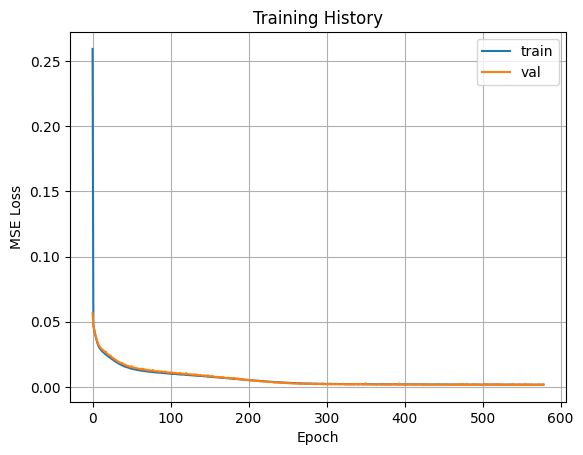

In [87]:
# Plot training history -- How well our model learns over time
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.savefig('traininghistory.png', dpi=300)
plt.show()

In [17]:
# Get final val loss
val_loss_std_units = history.history['val_loss'][-1]
val_rmse_std = np.sqrt(val_loss_std_units)

# Get std from scaler (for log(age) and Teff)
logage_std = np.sqrt(scaler_Y.var_[0])
teff_std = np.sqrt(scaler_Y.var_[1])

# Translate into physical units
logage_rmse = val_rmse_std * logage_std
teff_rmse = val_rmse_std * teff_std

print(f"RMSE in log(age): {logage_rmse:.4f} dex")
print(f"RMSE in Teff: {teff_rmse:.1f} K")

# Convert log(age) RMSE to % age error
age_factor = 10 ** logage_rmse
percent_error = (age_factor - 1) * 100
print(f"Age error factor: {age_factor:.3f}, (~{percent_error:.1f}% error)")


RMSE in log(age): 0.0227 dex
RMSE in Teff: 27.5 K
Age error factor: 1.054, (~5.4% error)


In [22]:
test_loss_std = model.evaluate(X_test, Y_test, verbose=0)
test_rmse_std = np.sqrt(test_loss_std)

logage_rmse_test = test_rmse_std * logage_std
teff_rmse_test = test_rmse_std * teff_std
age_factor_test = 10 ** logage_rmse_test

print(f"Test RMSE in log(age): {logage_rmse_test:.4f} dex")
print(f"Test RMSE in Teff: {teff_rmse_test:.1f} K")

age_factor = 10 ** logage_rmse_test
percent_error = (age_factor_test - 1) * 100
print(f"Age error factor: {age_factor_test:.3f}, (~{percent_error:.1f}% error)")


Test RMSE in log(age): 0.0200 dex
Test RMSE in Teff: 24.3 K
Age error factor: 1.047, (~4.7% error)


##### Now we will test this model on a set of stars from the [APOKASC3 catalog](https://ui.adsabs.harvard.edu/abs/2025ApJS..276...69P/abstract). These stars have ages linearly interpolated from the same YREC models used to train the data. We aim to evaluate how different the ANN model’s predicted values are from the original interpolated values.

In [23]:
# We need to apply the Salaris Correction (Salaris et al. 1993) to account for the heavy metal distribution in red giants
def salaris_corr(feh,afe):
    met = feh + np.log10(0.638*(10**afe) + 0.362)
    return met

In [ ]:
colnames = ['KEPLER_ID','initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age','flag']
columns = [
    "KEPLER_ID", "DR16_TEFF_COR", "DR16_TEFF_COR_ERR", "DR17_TEFF_COR", "DR17_TEFF_COR_ERR",
    "APOKASC3_EVSTATE", "APOKASC3_SEIS_SOURCE", "APOKASC3_SPEC_SOURCE", "APOKASC3_MASS", "APOKASC3_MASS_ERR",
    "APOKASC3_RADIUS", "APOKASC3_RADIUS_ERR", "APOKASC3_LOGG", "APOKASC3_LOGG_ERR", "APOKASC3_TEFF", "APOKASC3_TEFF_ERR",
    "APOKASC3_LOGG_SPEC", "APOKASC3_LOGG_SPEC_ERR", "APOKASC3_M_H", "APOKASC3_M_H_ERR",
    "APOKASC3_ALPHA_M", "APOKASC3_ALPHA_M_ERR", "APOKASC3_CAT_AGE", "APOKASC3_AGE_RGB",
    "APOKASC3_AGE_RGB_PERR", "APOKASC3_AGE_RGB_MERR", "GAIA_TEFF", "GAIA_RADIUS", "GAIA_LUMINOSITY"
]

df_subset = pd.read_csv("/home/l.morales/ML_ages/seis_yrec.csv",header=None,names=colnames)  # Linear interpolation results
df_subset2 = pd.read_csv("/home/l.morales/ML_ages/APOKASC3v2.csv",header=0,names=columns) # Original APOKASC3 data 
X_test = df_subset[['mass', 'met', 'logg']].copy()
X_test2 = df_subset2[['APOKASC3_MASS', 'APOKASC3_M_H', 'APOKASC3_LOGG']].copy()
X_test2['APOKASC3_M_H'] = salaris_corr(df_subset2['APOKASC3_M_H'], df_subset2['APOKASC3_ALPHA_M'])

# We are splittng up the stars that have converged in our linear interpolation method to use as validation of our ANN
X_test_clean = X_test[df_subset['flag'] == 0].copy() # Stars that converged using linear interpolation
X_full = X_test2.copy()

X_test_scaled = scaler_X.transform(X_test_clean) # Converged sample 
X_full_scaled = scaler_X.transform(X_full) # Full sample 

/home/l.morales/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/l.morales/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [26]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_Y.inverse_transform(predictions_scaled)

predictions_full_scaled = model.predict(X_full_scaled)
predictions_full = scaler_Y.inverse_transform(predictions_full_scaled)

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


In [27]:
# Filling columns for the converged data 
df_clean = df_subset[df_subset['flag'] == 0].copy()
df_clean['log_age_pred'] = predictions[:, 0]
df_clean['teff_pred'] = predictions[:, 1]
df_clean['age_pred'] = 10 ** df_clean['log_age_pred']

# Filling columns for the full sample 
df_full= df_subset2.copy()
df_full['log_age_pred'] = predictions_full[:, 0]
df_full['teff_pred'] = predictions_full[:, 1]
df_full['age_pred'] = 10 ** df_full['log_age_pred']

In [31]:
# Calculating offset between the predicted age vs. the linearly interpolated age relative to linear interp age
df_clean['age_offset'] = df_clean['age_pred'] - df_clean['age']
df_clean['frac_offset'] = df_clean['age_offset'] / df_clean['age']


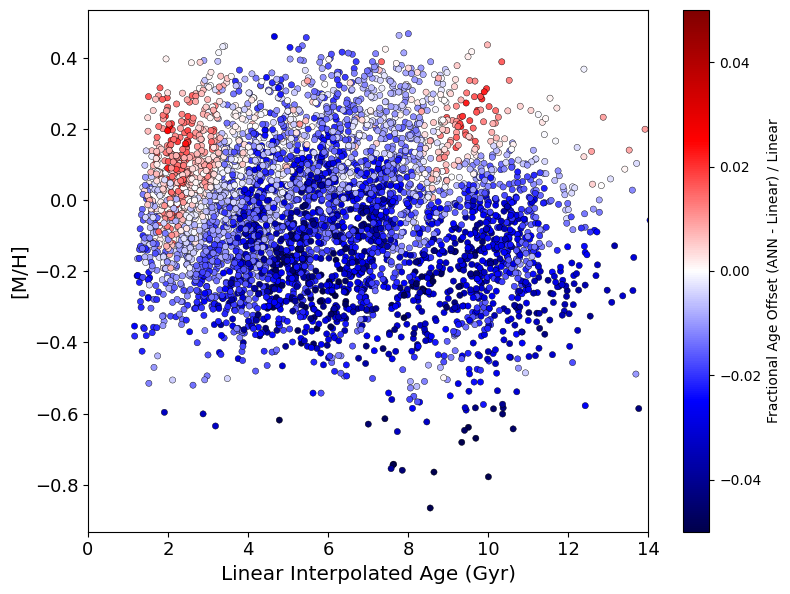

In [89]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['age'], df_clean['met'], 
                 c=df_clean['frac_offset'], cmap='seismic', s=20, edgecolor='k', linewidth=0.3,vmin=-0.05,vmax=0.05)

plt.colorbar(sc, label='Fractional Age Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Age (Gyr)',size='x-large')
plt.ylabel('[M/H]',size='x-large')
plt.xlim(0,14)
plt.tight_layout()
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('resultsANN.png')
plt.show()

In [34]:
mean_offset = df_clean['frac_offset'].mean()
std_offset = df_clean['frac_offset'].std()
print(f"Mean fractional offset: {mean_offset:.4f} ± {std_offset:.4f}")

Mean fractional offset: -0.0154 ± 0.0146


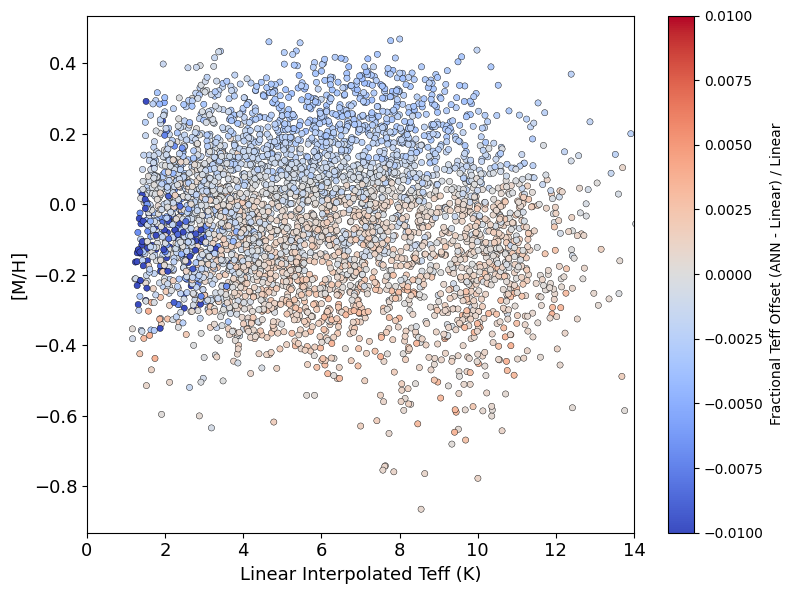

In [91]:
# Add fractional Teff offset column
df_clean['teff_offset'] = df_clean['teff_pred'] - df_clean['teff']
df_clean['frac_teff_offset'] = df_clean['teff_offset'] / df_clean['teff']

# Plot fractional Teff offset
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['age'], df_clean['met'], 
                 c=df_clean['frac_teff_offset'], cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3,
                 vmin=-0.01, vmax=0.01)  # You can adjust these limits if needed

plt.colorbar(sc, label='Fractional Teff Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Teff (K)',size=13)
plt.ylabel('[M/H]',size=13)
plt.xlim(0,14)
plt.tight_layout()
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('resultsANN_teff.png')
plt.show()

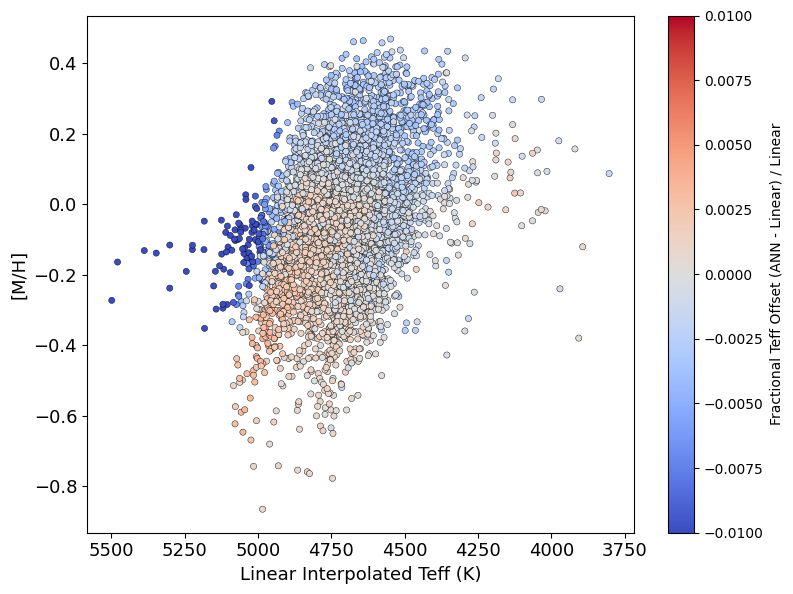

In [94]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_clean['teff'], df_clean['met'], 
                 c=df_clean['frac_teff_offset'], cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3,
                 vmin=-0.01, vmax=0.01)  # You can adjust these limits if needed

plt.colorbar(sc, label='Fractional Teff Offset (ANN - Linear) / Linear')
plt.xlabel('Linear Interpolated Teff (K)',size=13)
plt.ylabel('[M/H]',size=13)
# plt.xlim(0,14)
plt.tight_layout()
plt.gca().invert_xaxis()
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('resultsANN_teff.png')
plt.show()

In [38]:
mean_offset_teff = df_clean['frac_teff_offset'].mean()
std_offset_teff = df_clean['frac_teff_offset'].std()
print(f"Mean fractional Teff offset: {mean_offset_teff:.4f} ± {std_offset_teff:.4f}")


Mean fractional Teff offset: -0.0008 ± 0.0035


In [61]:
# Parameter space used for comparison (same used in training)
X = X_test2[['APOKASC3_MASS', 'APOKASC3_M_H', 'APOKASC3_LOGG']].values
y_pred = df_full['age_pred'].values

# Setup KNN
k = 5  # You can tune this
nn = NearestNeighbors(n_neighbors=k+1) 
nn.fit(X)

# Get neighbors for each star
distances, indices = nn.kneighbors(X)
neighbor_preds = np.array([y_pred[idxs[1:]] for idxs in indices])

# Compute mean and std of neighbor predictions
neighbor_mean = neighbor_preds.mean(axis=1)
neighbor_std = neighbor_preds.std(axis=1)

# Quantify how different each point is from its neighbors
z_score_like = (y_pred - neighbor_mean) / neighbor_std

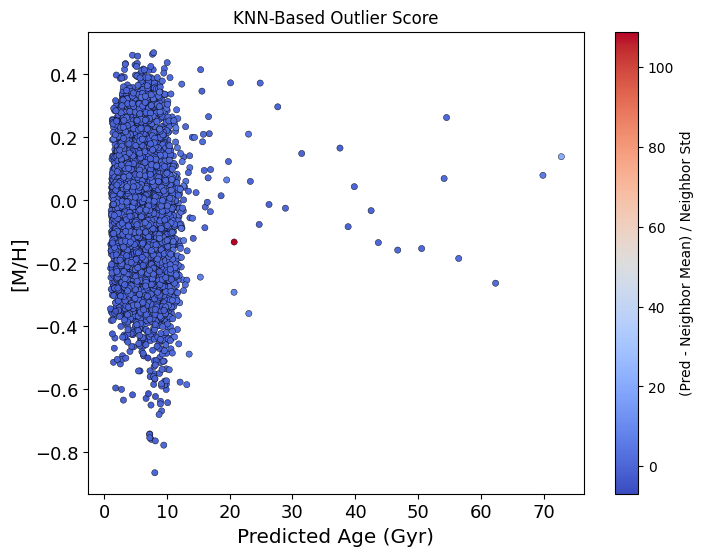

In [95]:
plt.figure(figsize=(8,6))
sc = plt.scatter(df_full['age_pred'], X_test2['APOKASC3_M_H'],
                 c=z_score_like, cmap='coolwarm', s=20, edgecolor='k', linewidth=0.3)
plt.colorbar(sc, label='(Pred - Neighbor Mean) / Neighbor Std')
plt.xlabel('Predicted Age (Gyr)',size='x-large')
plt.ylabel('[M/H]',size='x-large')
plt.title('KNN-Based Outlier Score')
plt.gca().tick_params(axis='both',labelsize=13)

# plt.xlim(0,14)
plt.show()


There is one data point that has a high score, but this is outside of the relevant ages (i.e. 0-14 gyrs) and so we will ignore that. :)

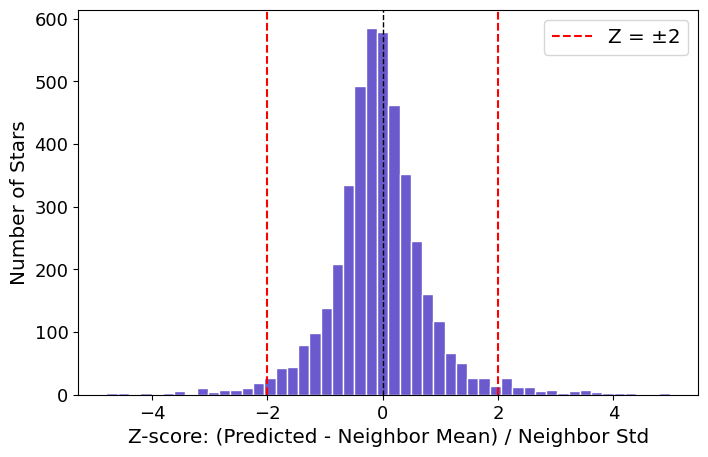

In [100]:
plt.figure(figsize=(8,5))
plt.hist(z_score_like[np.abs(z_score_like) < 5], bins=50, color='slateblue', edgecolor='white')
plt.axvline(0, color='k', linestyle='--', lw=1)
plt.axvline(2, color='r', linestyle='--', label='Z = ±2')
plt.axvline(-2, color='r', linestyle='--')
plt.xlabel('Z-score: (Predicted - Neighbor Mean) / Neighbor Std',size='x-large')
plt.ylabel('Number of Stars',size='x-large')
plt.legend(fontsize='x-large')
plt.gca().tick_params(axis='both',labelsize=13)
plt.savefig('zscorezoom.png')
plt.show()


Z-scores look great! We want them centered around 0 following a normal distribution, showing that our model isn't deviating from local expectations. 

In [85]:
# Below we assess whether stars near the edge of the parameter space 
# (mass, metallicity, logg) tend to have higher prediction deviations,
# by comparing their z-scores (ANN prediction vs local neighbors) 
MASS_IDX = 0
MET_IDX = 1
LOGG_IDX = 2

mass_min, mass_max = X[:, MASS_IDX].min(), X[:, MASS_IDX].max()
met_min, met_max   = X[:, MET_IDX].min(), X[:, MET_IDX].max()
logg_min, logg_max = X[:, LOGG_IDX].min(), X[:, LOGG_IDX].max()

delta = 0.02

is_edge = (
    (np.abs(X[:, MASS_IDX] - mass_min) < delta) |
    (np.abs(X[:, MASS_IDX] - mass_max) < delta) |
    (np.abs(X[:, MET_IDX] - met_min) < delta) |
    (np.abs(X[:, MET_IDX] - met_max) < delta) |
    (np.abs(X[:, LOGG_IDX] - logg_min) < delta) |
    (np.abs(X[:, LOGG_IDX] - logg_max) < delta)
)

In [86]:
edge_scores = np.abs(z_score_like[is_edge])
interior_scores = np.abs(z_score_like[~is_edge])

print(f"Edge stars: {len(edge_scores)}")
print(f"Interior stars: {len(interior_scores)}")

print("Mean z-score (edge):", edge_scores.mean())
print("Mean z-score (interior):", interior_scores.mean())


Edge stars: 50
Interior stars: 4289
Mean z-score (edge): 0.97388816
Mean z-score (interior): 0.64780575


The average z-score for stars at the edge of the grid is 0.97, while interior stars have a mean of 0.65. Both values fall below 1, indicating that predictions remain within $1\sigma$ of their local neighborhood across the entire parameter space.